In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re

In [5]:
import bz2


# Load a subset of the training data
with bz2.BZ2File(r"C:\Users\Admin\Desktop\ML CLASS SHERYIANS\DEEP LEARNING\KERAS DEEP -LEARNING BY NOOR\NLP-Social Media Posts Detection LSTM\train.ft.txt.bz2") as f:
    training_data = [f.readline().decode('utf-8').strip() for _ in range(3000)]

# Load a subset of the test data
with bz2.BZ2File(r"C:\Users\Admin\Desktop\ML CLASS SHERYIANS\DEEP LEARNING\KERAS DEEP -LEARNING BY NOOR\NLP-Social Media Posts Detection LSTM\test.ft.txt.bz2") as f:
    test_data = [f.readline().decode('utf-8').strip() for _ in range(1000)]

# Print the subset sizes
print("Training data subset size:", len(training_data))
print("Test data subset size:", len(test_data))

Training data subset size: 3000
Test data subset size: 1000


# Preparing Dataset

In [6]:
# Split the data into labels and texts
training_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
training_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

# Convert labels to binary (0 and 1)
training_labels = [0 if label == 1 else 1 for label in training_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]

In [7]:
test_labels[:4]

[1, 1, 0, 1]

In [8]:
test_texts[:4]

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of s

# Text Cleaning

In [9]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if not already downloaded
nltk.download('stopwords')

def clean_text(text):
    """Cleans text by lowercasing, removing stopwords, and applying stemming."""
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords, apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    # Join words back into a string
    return " ".join(words)

clean_text('I am Leaving this 123111727 number') 

# Apply function to training and test texts
training_texts=[clean_text(text) for text in training_texts]
test_texts=[clean_text(text) for text in test_texts]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
training_texts[0]

'stune even nongam sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen'

# Tokenization

In [11]:

# Tokenization and padding
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_texts)

X_train = tokenizer.texts_to_sequences(training_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [12]:
X_train[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  23,  82, 152, 177, 930, 280,  24,  10,  23,
         52, 451,  58,  33,  86,  58,  58,  64,  86,  32,  33,  42, 202,
         71, 747, 621, 731,  10, 452, 113, 247, 110],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 880,  64,
        198,  43,   3,  97,  45,  38,  32,  58, 880, 395, 346,  95,  4

In [13]:
X_train=np.array(X_train)
print(X_train.shape)

X_test=np.array(X_test)
print(X_test.shape)

y_train=np.array(training_labels)
print(y_train.shape)

y_test=np.array(test_labels)
print(y_test.shape)

(3000, 100)
(1000, 100)
(3000,)
(1000,)


# Training RNN

In [14]:

# Define improved RNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    SimpleRNN(128, return_sequences=True, dropout=0.3),  # RNN layer with dropout
    LayerNormalization(),  # Added normalization for stability
    SimpleRNN(128, dropout=0.3),  # Second RNN layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4917 - loss: 0.8862 - val_accuracy: 0.5010 - val_loss: 0.7809
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - accuracy: 0.5113 - loss: 0.8475 - val_accuracy: 0.4930 - val_loss: 0.7485
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 670ms/step - accuracy: 0.5073 - loss: 0.8301 - val_accuracy: 0.5060 - val_loss: 0.7289
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.5273 - loss: 0.8036 - val_accuracy: 0.5200 - val_loss: 0.7127
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 694ms/step - accuracy: 0.5023 - loss: 0.8079 - val_accuracy: 0.5210 - val_loss: 0.7027
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step - accuracy: 0.5157 - loss: 0.7829 - val_accuracy: 0.5350 - val_loss: 0.6952
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step - accuracy: 0.5230 - loss: 0.7627 - val_accuracy: 0.5500 - val_loss: 0.6920
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 786ms/step - accuracy: 0.5230 - loss: 0.7587 - val_accuracy: 0.5460 - val_loss: 0

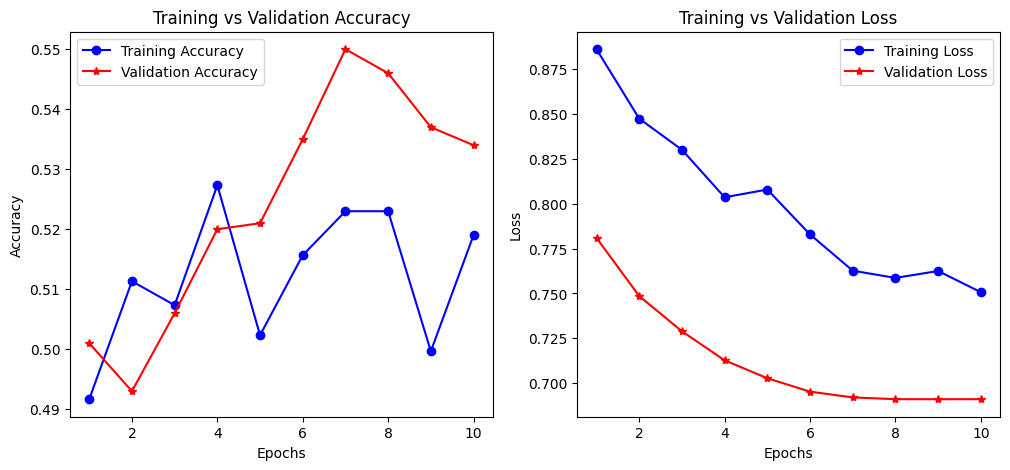

In [15]:
# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [16]:

# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Confusion Matrix:
[[290 208]
 [255 247]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.58      0.56       498
           1       0.54      0.49      0.52       502

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000



# Training LSTM

In [17]:

# Define improved model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),  # Added recurrent dropout
    LayerNormalization(),  # Added normalization for stability
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),  
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history =  model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/10


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5100 - loss: 0.9069 - val_accuracy: 0.5450 - val_loss: 0.6993
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.5293 - loss: 0.7982 - val_accuracy: 0.5590 - val_loss: 0.6882
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5410 - loss: 0.7738 - val_accuracy: 0.5670 - val_loss: 0.6821
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5600 - loss: 0.7380 - val_accuracy: 0.5850 - val_loss: 0.6614
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5843 - loss: 0.6955 - val_accuracy: 0.6060 - val_loss: 0.6563
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5920 - loss: 0.6900 - val_accuracy: 0.6100 - val_loss: 0.6503
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5970 - loss: 0.6803 - val_accuracy: 0.6250 - val_loss: 0.6445
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6183 - loss: 0.6503 - val_accuracy: 0.6160 - val_loss: 0.6427
Epoch 9/10
6/6 ━━━━

# Model Evaluation

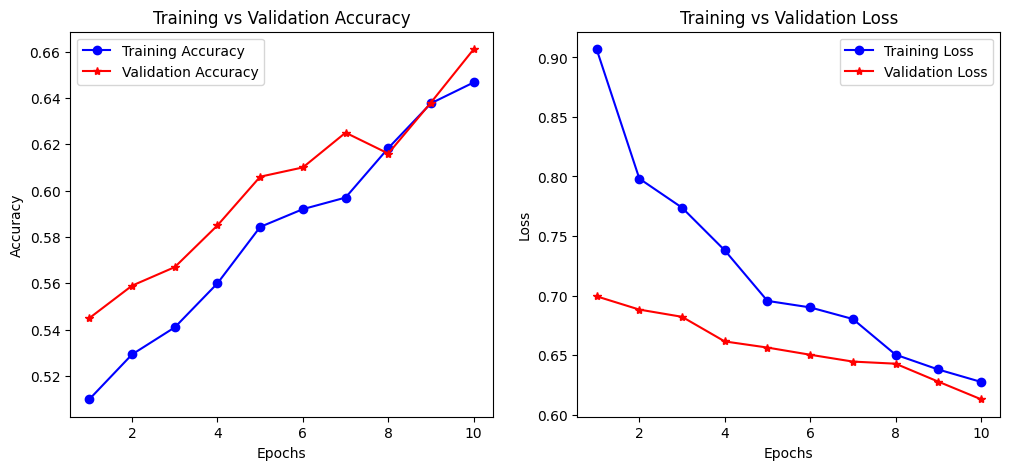

In [18]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [19]:

# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step
Confusion Matrix:
[[409  89]
 [250 252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       498
           1       0.74      0.50      0.60       502

    accuracy                           0.66      1000
   macro avg       0.68      0.66      0.65      1000
weighted avg       0.68      0.66      0.65      1000



# Training GRU

Epoch 1/10


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4997 - loss: 0.8537 - val_accuracy: 0.5020 - val_loss: 0.7711
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5143 - loss: 0.8244 - val_accuracy: 0.5310 - val_loss: 0.7550
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5340 - loss: 0.7877 - val_accuracy: 0.5400 - val_loss: 0.7397
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5317 - loss: 0.8040 - val_accuracy: 0.5430 - val_loss: 0.7274
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5507 - loss: 0.7623 - val_accuracy: 0.5530 - val_loss: 0.7153
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5533 - loss: 0.7459 - val_accuracy: 0.5630 - val_loss: 0.7045
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5520 - loss: 0.7565 - val_accuracy: 0.5680 - val_loss: 0.6956
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5760 - loss: 0.7279 - val_accuracy: 0.5750 - val_loss: 0.6886
Epoch 9/10
6/6 ━━━━━━━━━━━

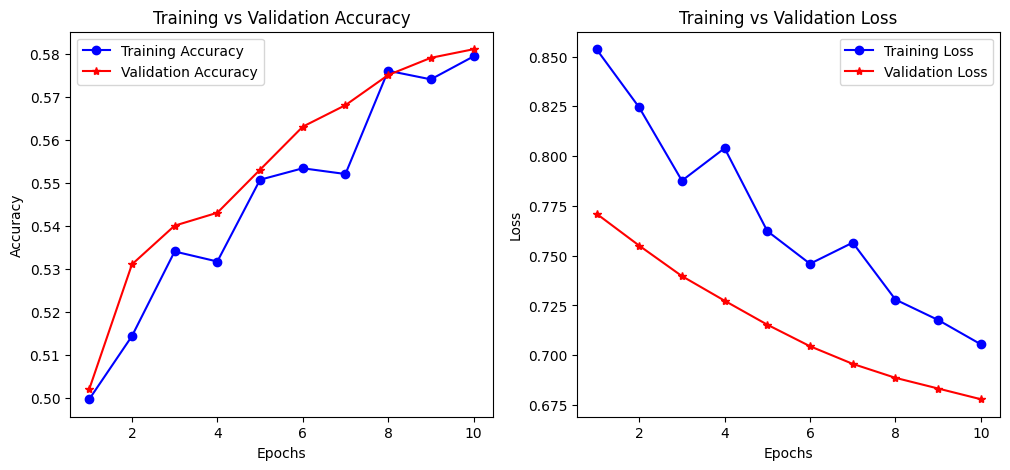

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
Confusion Matrix:
[[361 137]
 [282 220]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       498
           1       0.62      0.44      0.51       502

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.57      1000
weighted avg       0.59      0.58      0.57      1000



In [20]:
# Define improved GRU model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # GRU layer with dropout
    LayerNormalization(),  # Added normalization for stability
    GRU(128, dropout=0.3, recurrent_dropout=0.2),  # Second GRU layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()



# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Detection System

In [21]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiment
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Positive 😊 (Confidence: 0.5442)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Positive 😊 (Confidence: 0.5822)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Positive 😊 (Confidence: 0.5760)



In [22]:

model.save("lstm_model.h5")  # Saves architecture, weights & optimizer


import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [23]:

import tensorflow as tf
print(tf.__version__)

2.20.0
